In [1]:
import os
import sys
import time
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
%matplotlib inline

In [2]:
PATH = 'data/'

In [3]:
# parameters
batch_size = 20
num_workers = 0
num_epochs = 30
learining_rate = 0.01

In [4]:
data_transformation = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    
    'valid' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
    
    'test' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])        
    ]),
}

In [5]:
dataset = {x: ImageFolder(os.path.join(PATH, x), data_transformation[x]) for x in ['train', 'valid', 'test']}

In [6]:
dataloader = {x: DataLoader(dataset[x], 
                            batch_size=batch_size, 
                            shuffle=True,  
                            num_workers=num_workers) for x in ['train', 'valid', 'test']}

In [7]:
train_loader, valid_loader, test_loader = dataloader['train'], dataloader['valid'], dataloader['test']

In [8]:
dataset_size = {x: len(dataset[x]) for x in ['train', 'valid', 'test']}
dataset_size

{'train': 200, 'valid': 100, 'test': 40}

In [9]:
class_names = dataset['train'].classes
class_names

['cats', 'dogs']

In [10]:
def inverse_transform(inp):
    
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    return inp

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [13]:
# model 
model =models.resnet34(pretrained=True)
num_features = model.fc.in_features
model.fc     = nn.Linear(num_features, 3)
num_features

512

In [14]:
image, label = next(iter(train_loader))

In [15]:
output = model(image)
output

tensor([[-0.1450,  0.5870,  0.5679],
        [-0.1436, -0.4921, -0.0549],
        [-0.7818, -0.2052,  0.5691],
        [ 0.2102,  0.0487, -0.3802],
        [-0.0345,  0.2647, -0.2145],
        [-0.4909,  0.2032,  0.1101],
        [ 0.1393, -0.2577, -0.3952],
        [-0.4572,  0.1717,  0.2837],
        [-0.3385, -0.5489,  0.3213],
        [-0.0839,  0.3598,  0.1651],
        [-0.3122,  0.4761, -0.1208],
        [-1.3302, -0.4833,  0.4537],
        [-0.3919, -0.2018,  0.4812],
        [ 0.1456,  0.2241,  0.3167],
        [-0.4744, -0.2772,  0.2050],
        [ 0.0921, -0.0107, -0.1641],
        [ 0.0992, -0.7307,  0.4561],
        [ 0.0515, -0.3607,  0.3237],
        [ 0.3234,  0.3814,  0.4587],
        [-0.1398, -0.3470, -0.2233]], grad_fn=<AddmmBackward>)

In [17]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer 
optimizer = optim.SGD(model.parameters(), lr=learining_rate)

In [18]:
# train

In [19]:
image, label = next(iter(train_loader))
image.shape[1:]

torch.Size([3, 224, 224])

In [20]:
summary(model.cuda(), (image.shape[1:]))

AssertionError: Torch not compiled with CUDA enabled

In [21]:
# fine tuning

In [22]:
if torch.cuda.is_available():
    model.cuda()

In [23]:
# train

In [ ]:
%%time

valid_loss_min = np.Inf

print('*' * 39)
print('Epoch \tTraining Loss \tValidation Loss')
for epoch in range(1, num_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
       
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        optimizer.zero_grad()
        
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        loss.backward()
        
        # update model parameters
        optimizer.step()
        
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    # validate the model
    model.eval()
    for data, target in valid_loader:
      
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
      
        output = model(data)

        loss = criterion(output, target)
        
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
      
    # print training/validation statistics 
    print('{}\t\t{:.3f}\t\t{:.3f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        torch.save(model.state_dict(), 'mandela.pt')
        valid_loss_min = valid_loss

***************************************
Epoch 	Training Loss 	Validation Loss


In [26]:
# load model
model.load_state_dict(torch.load('mandela.pt'))

In [27]:
def test(test_loader,batch_size ):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    # specify the image classes
    classes = ['cat','dog'] 

    model.eval()
    # iterate over test data
    for data, target in test_loader:
        
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        
        # calculate the batch loss
        loss = criterion(output, target)
        
        # update test loss 
        test_loss += loss.item()*data.size(0)
        
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        
        correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
        
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(2):
        if class_total[i] > 0:
            print('Test accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest accuracy : %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [28]:
test(test_loader, batch_size)

Test Loss: 0.264702

Test accuracy of   cat: 85% (17/20)
Test accuracy of   dog: 90% (18/20)

Test accuracy : 87% (35/40)


In [29]:
def visualize(model, num_images=6):
    
    training_mode = model.training
    model.eval()
    images_so_far = 0
    

    for i, data in enumerate(valid_loader):
        
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = torch.autograd.Variable(inputs.cuda()), torch.autograd.Variable(labels.cuda())
        else:
            inputs, labels = torch.autograd.Variable(inputs), torch.autograd.Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            plt.subplot(2, int(num_images/2), images_so_far)
            plt.imshow(inverse_transform(inputs.cpu().data[j]))
            plt.title('predicted: {}'.format(class_names[preds[j]]), fontsize=16)
            plt.tight_layout()
            plt.xticks([])
            plt.yticks([])
            #ax.axis('off')
    
            if images_so_far == num_images:
                model.train(mode=training_mode)
                return
    model.train(mode=training_mode)

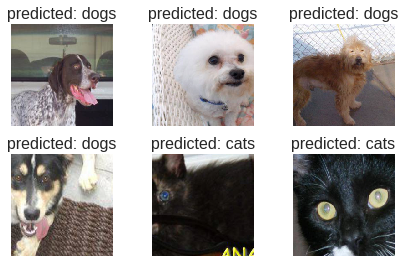

In [30]:
visualize(model)